<h3>Summary</h3>

<p>
For this project, we will be creating a continuous bag-of-words (CBOW) model to represent and compare the vocabulary of a corpus in terms of word embeddings. We will use these word embeddings to measure the similarity between a sample of words from that vocabulary.
</p>

<p>
The following code will be written in Python 3 with the following dependencies: keras, matplotlib, nltk, scikit-learn, spacy, numpy, and pandas. The text to be used will be Franklin D. Roosevelt's first inaugural address from NLTK's "Inaugural" corpus. There are some drawbacks to using a small corpus such as a single speech; these will be apparent in the final results.
</p>

<p>
<b>Preprocessing.</b> NLTK's built-in sent_tokenize and word_tokenize were used to create a 2D list of sentences and their words as individual tokens. After examining the speech, these functions seemed to produce the desired results. A list of punctuation symbols was also determined to exhaust all punctuation that was present upon examination. NLTK's built-in stopwords list was used, as the speech was deemed modern enough for it to capture most relevant tokens. Then, Spacy's WordNet Lemmatizer was used to lemmatize words so declensions would be considered identical to facilitate training on such a small corpus. All words were also converted to lowercase.
</p>

<p>
<b>The CBOW Model.</b> The implementation of the CBOW model, including the functions for deriving its component variables, training it, sampling it, and visualizing it were taken, and in some cases adapted, from Sarkar 2019 and Scrivner 2019.
</p>

<h3>Import Statements</h3>

In [1]:
import keras.backend as K
import matplotlib.pylab as plt
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from nltk.corpus import inaugural, stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE
import spacy, numpy, pandas, os

<h3>Retrieving Text</h3>

In [2]:
names = inaugural.fileids()
speech = inaugural.raw(fileids = names[36]) # FDR 1933

<h3>Preprocessing Corpus</h3>

In [3]:
def preprocess(text):
    
    sentences = sent_tokenize(text)
    
    punctuation = ['.', ',', ';', '!', '?', '--']
    sw = stopwords.words('english')
    nlp = spacy.load('en_core_web_sm')
    
    lemmas = []
    
    for sentence in sentences: # Lemmatize
        lemmas.append([word.lemma_ for word in nlp(sentence) if word.lemma_ != '-PRON-'])
        
    tokens = []
    
    for sentence in lemmas: # Lowercase; remove stopwords and punctuation
        tokens.append([word.lower() for word in sentence
                       if word.lower() not in punctuation
                       and word.lower() not in sw
                       and word != "\'s"])
    
    corpus = []
    
    for sentence in tokens:
        tmp = ' '.join(sentence)
        corpus.append(tmp)
    
    return corpus

In [4]:
corpus = preprocess(speech)

<h3>Building Corpus Vocabulary</h3>

In [5]:
def word2id(corpus):
    
    tokenizer = text.Tokenizer()
    tokenizer.fit_on_texts(corpus)
    
    return tokenizer.word_index

In [6]:
word2id = word2id(corpus)

In [7]:
word2id['PAD'] = 0

In [8]:
def id2word(word2id):

    return {v:k for k, v in word2id.items()}

In [9]:
id2word = id2word(word2id)

In [10]:
def wids(corpus, word2id):
    
    return [[word2id[word] for word in text.text_to_word_sequence(token)] for token in corpus]

In [11]:
wids = wids(corpus, word2id)

<h3>Generating Context Windows</h3>

In [12]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    
    context_length = window_size*2
    
    for words in corpus:
        
        sentence_length = len(words)
        
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [13]:
def get_samples(n, window_size = 2, vocab_size = len(word2id)):
    
    samples = []
    
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size = window_size, vocab_size = vocab_size):
        if 0 not in x[0]:
            
            samples.append(([id2word[w] for w in x[0]], id2word[numpy.argwhere(y[0])[0][0]]))
    
            if i == n-1:
                break
            i += 1
            
    return samples

In [14]:
def print_samples(n):

    samples = []

    for i in get_samples(n):
        context = ', '.join(i[0])
        target = i[1]
        samples.append((context, target))

    table = pandas.DataFrame(samples, columns = ['Context', 'Target'])
    output = table.style.set_properties(**{'text-align': 'left'})
    output = output.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])
  
    display(output)

In [15]:
print_samples(5)

,Context,Target
0,"certain, fellow, expect, induction",americans
1,"fellow, americans, induction, presidency",expect
2,"americans, expect, presidency, address",induction
3,"expect, induction, address, candor",presidency
4,"induction, presidency, candor, decision",address


<h3>Building CBOW Model</h3>

In [16]:
def build_CBOW(window_size = 2, vocab_size = len(word2id), embed_size = 100):
    
    cbow = Sequential()
    
    cbow.add(
        Embedding(
        input_dim = vocab_size, 
        output_dim = embed_size, 
        input_length = window_size * 2
        )
    )
    
    cbow.add(
        Lambda(
            lambda x: K.mean(x, axis=1), 
            output_shape=(embed_size,)
        )
    )
    
    cbow.add(
        Dense(
            vocab_size, 
            activation='softmax'
        )
    )
    
    cbow.compile(
        loss='categorical_crossentropy', 
        optimizer='rmsprop'
    )
    
    return cbow

In [17]:
cbow = build_CBOW()
cbow.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 100)            56700     
_________________________________________________________________
lambda (Lambda)              (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 567)               57267     
Total params: 113,967
Trainable params: 113,967
Non-trainable params: 0
_________________________________________________________________


<h3>Training CBOW Model</h3>

In [18]:
def train_CBOW(epochs, cbow = cbow, corpus = wids, window_size = 2, vocab_size = len(word2id)):
    
    train_CBOW = []
    
    for epoch in range(1, epochs + 1):
        loss = 0.
        i = 0
        for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
            i += 1
            loss += cbow.train_on_batch(x, y)

        train_CBOW.append((epoch, loss))
    
    return train_CBOW

In [19]:
train_CBOW = train_CBOW(100)

In [20]:
train_table = pandas.DataFrame(train_CBOW, columns = ['Epoch ', 'Loss'])
print(
    train_table.to_string(
        index = False,
        justify = 'center',
        col_space = (0, 15),
        max_rows = 10
    )
)

 Epoch        Loss     
    1     5776.512186  
    2     5713.540808  
    3     5645.282699  
    4     5570.075523  
    5     5487.286491  
...                 ...
   96     1891.273389  
   97     1879.985086  
   98     1868.937237  
   99     1858.135015  
  100     1847.562225  


<h3>Determining Word Embedding Similarity</h3>

In [21]:
weights = cbow.get_weights()[0]
weights = weights[1:]

In [22]:
def similar_words(weights, search_terms):
    distance_matrix = euclidean_distances(weights)

    similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in search_terms}

    return similar_words

In [23]:
search_terms = ['leadership', 'government', 'constitution', 'emergency', 'economy']
similar_words = similar_words(weights, search_terms)

In [24]:
table_similar_words = pandas.DataFrame(similar_words)
display(table_similar_words)

,leadership,government,constitution,emergency,economy
0,convinced,federal,simple,fact,currency
1,understanding,arrangement,favor,accomplishment,less
2,advance,fall,less,foe,line
3,rise,transportation,always,befit,provision
4,property,communication,line,wait,presently


<h3>Visualizing Word Embedding Distance</h3>

In [30]:
def visualize_distance(similar_words = similar_words, word2id = word2id):
    
    words = sum([[k] + v for k,v in similar_words.items()], [])
    words = list(set(words))
    words_ids = [word2id[w] for w in words]
    word_vectors = numpy.array([weights[idx] for idx in words_ids])
    
    print("Total Words: ", len(words), "\tWord Embedding Shapes: ", word_vectors.shape)
    
    tsne = TSNE(
        n_components = 2, 
        random_state = 0,
        n_iter = 10000,
        perplexity = 3
    )
    
    numpy.set_printoptions(suppress = True)
    
    T = tsne.fit_transform(word_vectors)
    
    labels = words
    plt.figure(figsize = (16, 10))
    plt.scatter(
        T[:, 0], T[:, 1], 
        c = "steelblue",
        edgecolors = "k",
        s = 40
    )
    
    for label, x, y in zip(labels, T[:, 0], T[:, 1]):
        plt.annotate(
            label,
            xy = (x + 1, y + 1),
            xytext = (-5, 7),
            textcoords = "offset points",
            fontsize = 12
        )

Total Words:  28 	Word Embedding Shapes:  (28, 100)


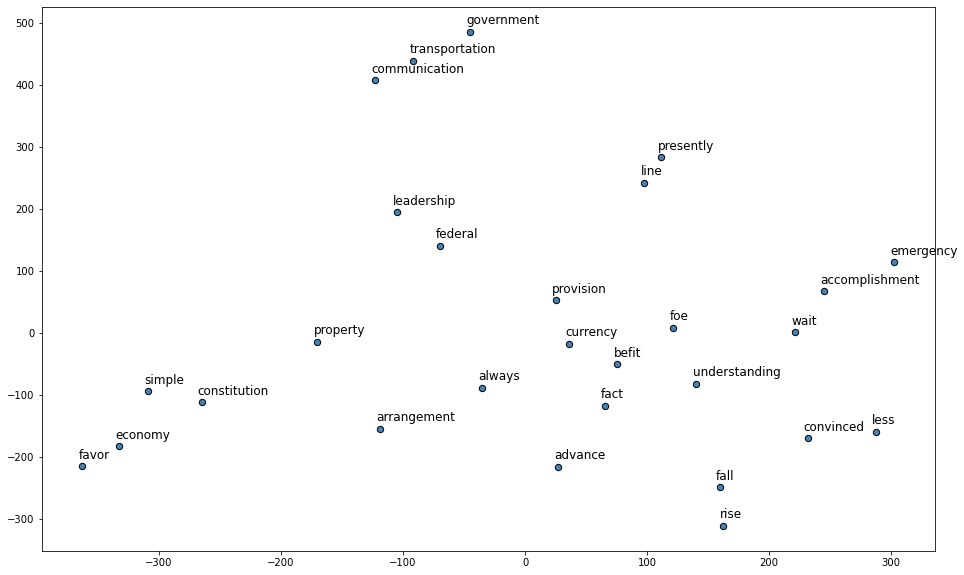

In [31]:
visualize_distance()

<h3>Reference List</h3>
<p>
Scrivner, Olga. (2019, October 7). <i>Introduction to word vectors - cbow</i> [Video]. Youtube. <br> 
    &nbsp;&nbsp;&nbsp;&nbsp; https://www.youtube.com/watch?v=ocUshGwOSsQ <br>
Sarkar, Dipanjan. 2019. <i>Text Analytics with Python: A Practical Real-World Approach to <br> 
    &nbsp;&nbsp;&nbsp;&nbsp; Gaining Actionable Insights from Your Data</i>. Apress. https://doi.org/10.1007/978-1-4842-4354-1
</p>